# Demo Notebook

In [1]:
import requests
import polars as pl
import polars.selectors as cs
from plotnine import *
from great_tables import *

## Data Retrieval

In [2]:
res = []
url = 'https://www.federalregister.gov/api/v1/documents.json?fields[]=document_number&fields[]=excerpts&fields[]=page_length&fields[]=president&fields[]=publication_date&fields[]=raw_text_url&fields[]=signing_date&fields[]=title&fields[]=toc_subject&fields[]=topics&per_page=20&conditions[publication_date][gte]=2005-01-20&conditions[presidential_document_type][]=executive_order&conditions[president][]=george-w-bush&conditions[president][]=barack-obama&conditions[president][]=donald-trump&conditions[president][]=joe-biden&conditions[president][]=donald-trump'

while url != '':

    # retrieve results
    response = requests.get(url)
    response.raise_for_status()
    res_temp = response.json()
    res += [res_temp]

    # get next url
    url = res_temp.get('next_page_url','')

## Data Cleaning

In [3]:
df_res = (
    pl.DataFrame(res)
    .select('results')
    .explode('results')
    .unnest('results')
    .unnest('president')
)
df_res.glimpse()

Rows: 969
Columns: 11
$ document_number         <str> '2025-14212', '2025-14217', '2025-14218', '2025-13925', '2025-12961', '2025-12962', '2025-12774', '2025-12775', '2025-12505', '2025-12506'
$ excerpts               <null> None, None, None, None, None, None, None, None, None, None
$ page_length             <i64> 4, 3, 3, 3, 2, 2, 3, 2, 1, 5
$ identifier              <str> 'donald-trump', 'donald-trump', 'donald-trump', 'donald-trump', 'donald-trump', 'donald-trump', 'donald-trump', 'donald-trump', 'donald-trump', 'donald-trump'
$ name                    <str> 'Donald Trump', 'Donald Trump', 'Donald Trump', 'Donald Trump', 'Donald Trump', 'Donald Trump', 'Donald Trump', 'Donald Trump', 'Donald Trump', 'Donald Trump'
$ publication_date        <str> '2025-07-28', '2025-07-28', '2025-07-28', '2025-07-23', '2025-07-10', '2025-07-10', '2025-07-09', '2025-07-09', '2025-07-03', '2025-07-03'
$ raw_text_url            <str> 'https://www.federalregister.gov/documents/full_text/text/2025/07/28/2

In [4]:
# lookup table

term = [1,2,1,2,1,1,2]
start_year = [2001, 2005, 2009, 2013, 2017, 2021, 2025]
start_date = [f'{year}-01-20' for year in start_year]
end_date = start_date[1:] + ['2029-01-20']
president_lname = ['Bush']*2 + ['Obama']*2 + ['Trump'] + ['Biden'] + ['Trump']
df_lkup = pl.DataFrame([term, start_year, start_date, end_date, president_lname], 
                       schema = ['term','start_year','start_date', 'end_date', 'president_lname'],
                       orient = 'col')
df_lkup

In [5]:
df_clean = (
    df_res
    .with_columns(
        president_lname = pl.col('identifier')
                            .str.extract('[A-Za-z ]+-([A-Za-z]+$)', group_index = 1)
                            .str.to_titlecase(),
    )
    # there's a bug in polars join_asof() at the time of writing...
    .join(df_lkup, on = 'president_lname')
    .filter( pl.col('signing_date') >= pl.col('start_date'))
    .filter( pl.col('signing_date') <  pl.col('end_date'))
    .with_columns( pres_term = pl.concat_str( pl.col('president_lname'), pl.lit(' - '), pl.col('term')) )
)
df_clean.glimpse()

Rows: 952
Columns: 17
$ document_number         <str> '2025-14212', '2025-14217', '2025-14218', '2025-13925', '2025-12961', '2025-12962', '2025-12774', '2025-12775', '2025-12505', '2025-12506'
$ excerpts               <null> None, None, None, None, None, None, None, None, None, None
$ page_length             <i64> 4, 3, 3, 3, 2, 2, 3, 2, 1, 5
$ identifier              <str> 'donald-trump', 'donald-trump', 'donald-trump', 'donald-trump', 'donald-trump', 'donald-trump', 'donald-trump', 'donald-trump', 'donald-trump', 'donald-trump'
$ name                    <str> 'Donald Trump', 'Donald Trump', 'Donald Trump', 'Donald Trump', 'Donald Trump', 'Donald Trump', 'Donald Trump', 'Donald Trump', 'Donald Trump', 'Donald Trump'
$ publication_date        <str> '2025-07-28', '2025-07-28', '2025-07-28', '2025-07-23', '2025-07-10', '2025-07-10', '2025-07-09', '2025-07-09', '2025-07-03', '2025-07-03'
$ raw_text_url            <str> 'https://www.federalregister.gov/documents/full_text/text/2025/07/28/2

In [6]:
df_agg = (
    df_clean
    .group_by('pres_term')
    .agg(
        n_eo_issued = pl.col('document_number').count(),
        start_date = pl.col('publication_date').min()
    )
)

df_agg.sort('start_date')

In [7]:
df_cumul = (
    df_clean
    .with_columns( cs.ends_with('date').cast(pl.Date) )
    .with_columns(
        day_since_start = ( pl.col('signing_date') - pl.col('start_date') ).dt.total_days(),
        term_label = pl.concat_str( pl.lit('('), pl.col('start_date').dt.year(), pl.lit(')'),
                                    pl.lit('\n'),
                                    pl.col('president_lname') )
    )
    .group_by('pres_term', 'term_label', 'day_since_start', 'signing_date')
    .len()
    .with_columns( n_cumul = pl.col('len').cum_sum().over('pres_term', order_by = 'day_since_start') )
)
df_cumul.sort('pres_term', 'day_since_start').glimpse()

Rows: 711
Columns: 6
$ pres_term        <str> 'Biden - 1', 'Biden - 1', 'Biden - 1', 'Biden - 1', 'Biden - 1', 'Biden - 1', 'Biden - 1', 'Biden - 1', 'Biden - 1', 'Biden - 1'
$ term_label       <str> '(2021)\nBiden', '(2021)\nBiden', '(2021)\nBiden', '(2021)\nBiden', '(2021)\nBiden', '(2021)\nBiden', '(2021)\nBiden', '(2021)\nBiden', '(2021)\nBiden', '(2021)\nBiden'
$ day_since_start  <i64> 0, 1, 2, 5, 6, 7, 8, 13, 15, 21
$ signing_date    <date> 2021-01-20, 2021-01-21, 2021-01-22, 2021-01-25, 2021-01-26, 2021-01-27, 2021-01-28, 2021-02-02, 2021-02-04, 2021-02-10
$ len              <u32> 9, 8, 2, 2, 1, 2, 1, 3, 1, 1
$ n_cumul          <u32> 9, 17, 19, 21, 22, 24, 25, 28, 29, 30

Rows: 711
Columns: 6
$ pres_term        <str> 'Biden - 1', 'Biden - 1', 'Biden - 1', 'Biden - 1', 'Biden - 1', 'Biden - 1', 'Biden - 1', 'Biden - 1', 'Biden - 1', 'Biden - 1'
$ term_label       <str> '(2021)\nBiden', '(2021)\nBiden', '(2021)\nBiden', '(2021)\nBiden', '(2021)\nBiden', '(2021)\nBiden', '(2021)\nB

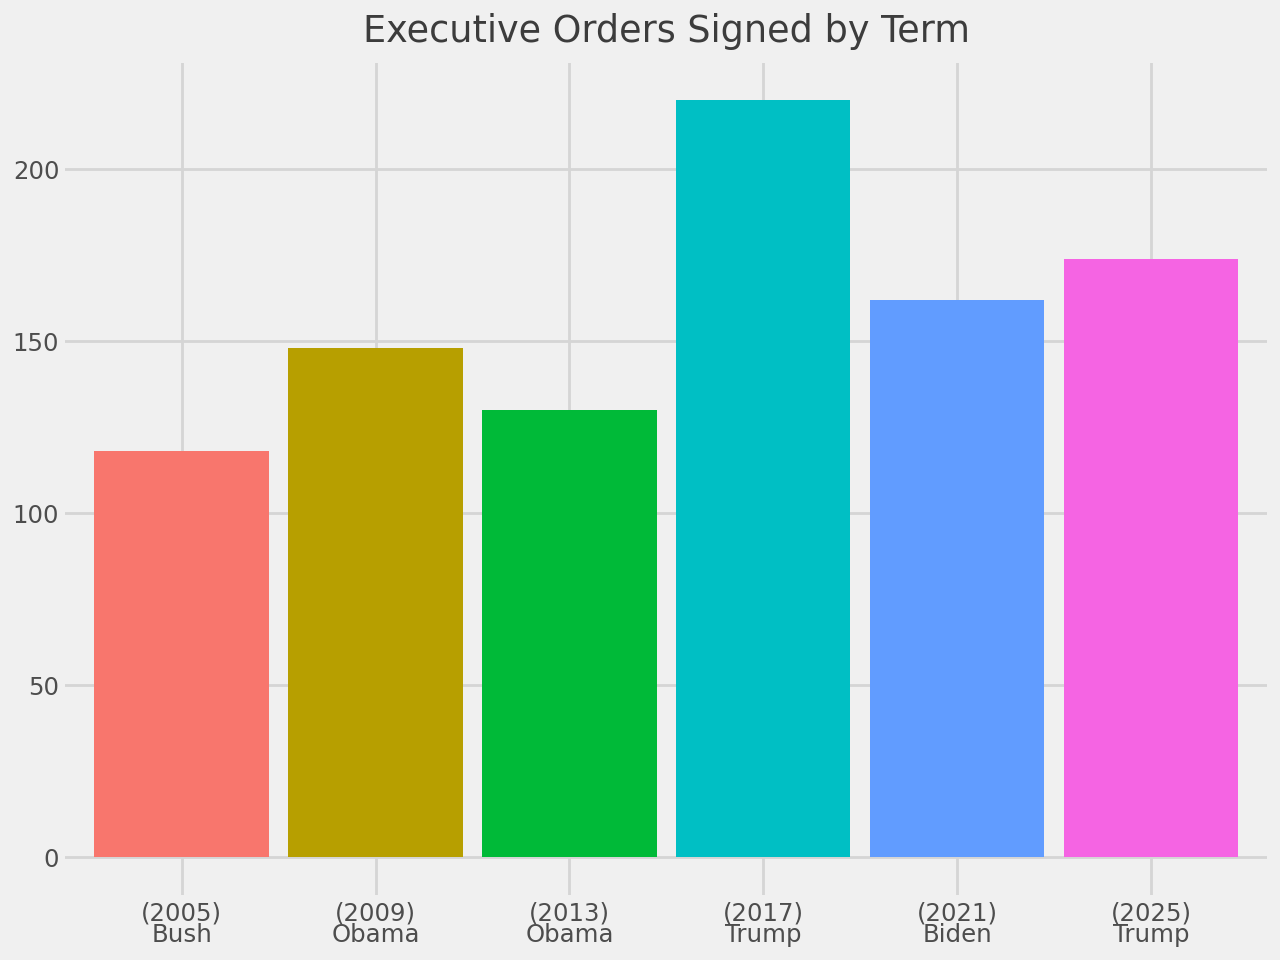

In [8]:
# plot not included in final; the first plot you make often isn't the best!
# for example, this one has censored data because (as of writing in 2025, Trump 2 is not complete)

(
ggplot(df_cumul.group_by('term_label').agg( pl.col('n_cumul').max() )) +
aes(x = 'term_label', y = 'n_cumul', fill = 'term_label') +
geom_col() +
labs(title = 'Executive Orders Signed by Term', x = '', y = '') +
theme_538() +
scale_color_brewer('qual', palette = 'Set1') +
theme(legend_position = 'none')
)

In [9]:
(
ggplot(df_cumul) +
aes(x = 'day_since_start', y = 'n_cumul', color = 'term_label') +
geom_line() +
labs(
    title = 'Executive Orders Signed by Days in Office',
    x = 'Days since Term Start', 
    y = 'EOs Issued', 
    color = 'Term') +
theme_538() +
scale_color_brewer('qual', palette = 'Set1') +
theme(legend_position = 'bottom')
)

In [10]:
df_pit = (
  df_cumul
  .with_columns( max_dss = pl.when( pl.col('signing_date') == pl.col('signing_date').max() )
                             .then( pl.col('day_since_start') )
                             .otherwise( None )
                             .max()
  )
  .group_by('term_label', 'max_dss')
  .agg( 
    n_ttl_pit = pl.when( pl.col('day_since_start') <= pl.col('max_dss') ).then(pl.col('n_cumul')).otherwise(None).max(),
    n_ttl = pl.col('n_cumul').max(),
   )
   .with_columns( 
      n_ttl = pl.when( pl.col('term_label') == pl.col('term_label').max())
                .then(None)
                .otherwise( pl.col('n_ttl')) )
  .sort('term_label')
)

n_days_in_office = df_pit.get_column('max_dss')[0]

(
  GT(df_pit)
  .cols_hide('max_dss')
  .tab_header(
    title = 'Executive Orders Issued by Term',
    subtitle = f'Normalized for first {n_days_in_office} days in office' +
               f' ({n_days_in_office * 100 / (365*4 + 1):.1f}% of term)')
  .tab_spanner(
        label="Count",
        columns= cs.contains("ttl")
    )
  .cols_label(
    term_label = 'Term',
    n_ttl_pit = 'Point in time',
    n_ttl = 'Full term'
  )
  .cols_align('center')
  .sub_missing(missing_text="-")
  .opt_row_striping()
)

I have some thoughts…